In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import MinMaxScaler
import json
import pmdarima as pm
import sys
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import pylab
from typing import Tuple

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

from ts_analyzer import ts_analyzer
from model import i_model

ModuleNotFoundError: No module named 'model'

# Reading data

In [2]:
daily_jumpsup_csv_path = "data/archive/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"

original_df = pd.read_csv(
    daily_jumpsup_csv_path, parse_dates=True, index_col="timestamp"
)

original_df = original_df.resample("h").agg(np.mean)

with open("data/archive/combined_windows.json") as f:
  true_anomalies = json.load(f)

true_anomalies_range = true_anomalies["artificialWithAnomaly/art_daily_jumpsup.csv"][0]

# Data preprocessing

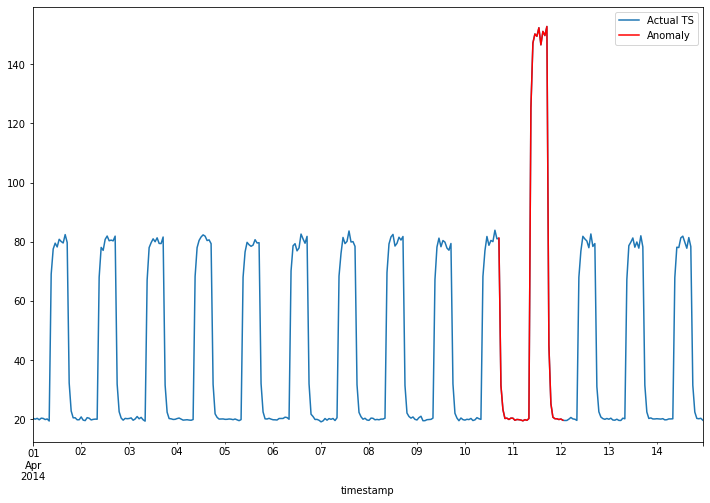

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
original_df_subset = original_df.loc[true_anomalies_range[0]:true_anomalies_range[1]]
original_df.plot(ax=ax)
original_df_subset.plot(ax=ax, color="r")
plt.legend(["Actual TS", "Anomaly"])
plt.show()

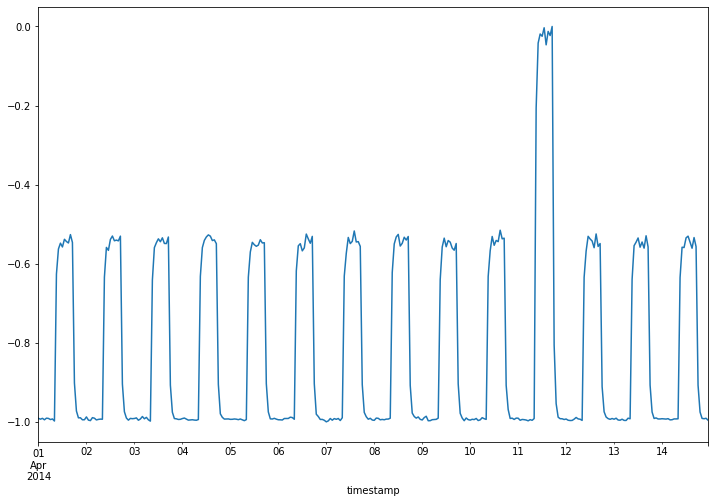

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 0))
original_df["value"] = scaler.fit_transform(original_df.values)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
original_df.plot(legend=False, ax=ax)
plt.show()

In [5]:
tsa = ts_analyzer.TsAnalyzer(original_df)
print("Is TS stationary: ", tsa.is_stationary())


Statistics analysis

Statistic Test :  -8.848107476407737
p-value :  1.600138263816873e-14
# n_lags :  12
No of observation:  323
 critical value 1% : -3.4507587628808922
 critical value 5% : -2.870530068560499
 critical value 10% : -2.5715597727381647
Is TS stationary:  True


/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


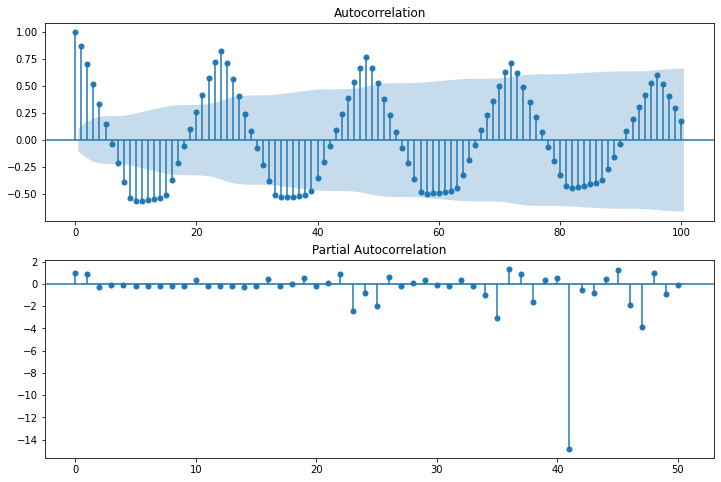

In [6]:
f = plt.figure()
f.set_size_inches(12, 8)
ax = f.add_subplot(2, 1, 1); _ = sm.graphics.tsa.plot_acf(original_df.values, lags=100, ax=ax)
ax2 = f.add_subplot(2, 1, 2); _ = sm.graphics.tsa.plot_pacf(original_df.values, lags=50, ax=ax2)

# SARIMA


In [9]:


first_training_samples = int(len(original_df)/2)
model = SARIMAX(original_df[:first_training_samples].values, order=(0, 0, 0), seasonal_order=(1,0,1,24), enforce_stationarity = True, enforce_invertibility = False)

model_fit = model.fit(dsip=-1)
model_fit.summary()

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  168
Model:             SARIMAX(1, 0, [1], 24)   Log Likelihood                 446.345
Date:                    Tue, 23 Mar 2021   AIC                           -886.690
Time:                            09:50:11   BIC                           -877.318
Sample:                                 0   HQIC                          -882.886
                                    - 168                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9999   3.82e-05   2.62e+04      0.000       1.000       1.000
ma.S.L24      43.0041   2.69e-10    1.6e+11      0.000      43.004      43.004
sigma2      4.687e-08   4.63e-09     10.113      0.000    3.78e-08     5.6e-08
===================================================================================
Ljung-Box (L1) (Q):                  22.83   Jarque-Bera (JB):                 3.82
Prob(Q):                              0.00   Prob(JB):                         0.15
Heteroskedasticity (H):               0.70   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.03e+24. Standard errors may be unstable.
"""

0.9978987232877341
0.018005610307012553
1.0142026086677254


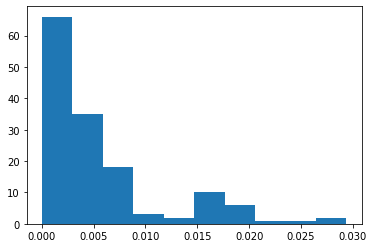

In [39]:
absolute_error = np.abs(model_fit.resid)
print(np.max(absolute_error))
print(np.quantile(absolute_error, 0.8))
print(absolute_error.mean() + 3 * absolute_error.std())

threshold = np.quantile(absolute_error, 0.95)

absolute_error = absolute_error[absolute_error < 0.1]
plt.hist(absolute_error)
threshold = np.max(absolute_error)

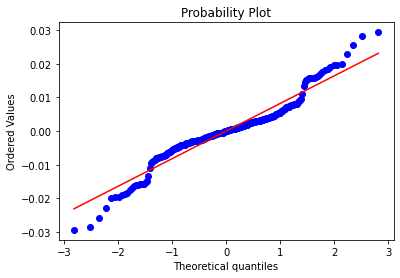

In [13]:
absolute_error_2 = np.array([-err for err in absolute_error])
error_dist = np.concatenate((absolute_error, absolute_error_2))
stats.probplot(error_dist, dist="norm", plot=pylab)
pylab.show()

Text(0, 0.5, 'Error')

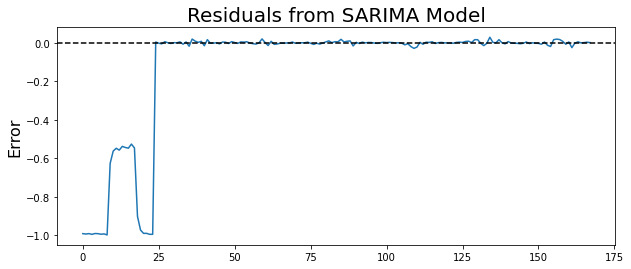

In [108]:
plt.figure(figsize=(10,4))
plt.plot(model_fit.resid)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [15]:
num_forecast = 100
y_pred = model_fit.forecast(num_forecast)

In [16]:
pred_df = pd.DataFrame(y_pred, columns=["Predicted"], index=original_df[first_training_samples:first_training_samples+num_forecast].index)

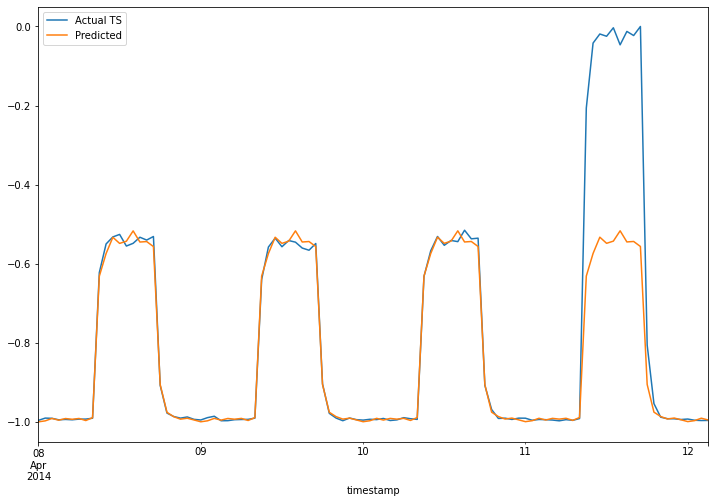

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
original_df[first_training_samples:first_training_samples+num_forecast].plot(ax=ax)
pred_df.plot(ax=ax)
plt.legend(["Actual TS", "Predicted"])
plt.show()

In [18]:
residuals = original_df[first_training_samples:first_training_samples+num_forecast].values - pred_df.values
absolute_error = np.abs(residuals)

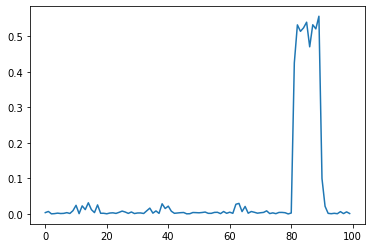

In [19]:
plt.plot(absolute_error)
detected_anomalies = np.where(absolute_error > threshold)

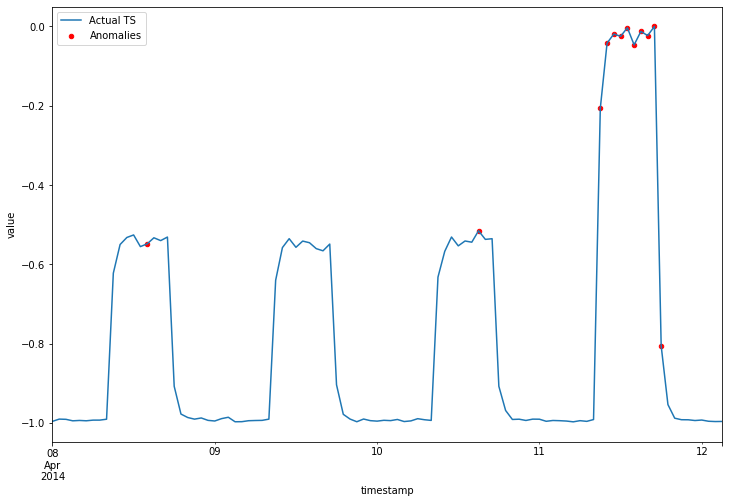

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

detected_anomalies_df = original_df.iloc[first_training_samples + detected_anomalies[0]]
original_df[first_training_samples:first_training_samples+num_forecast].plot(ax=ax)
detected_anomalies_df.reset_index().plot.scatter(x="timestamp", y="value", ax=ax, color="r")
plt.legend(["Actual TS", "Anomalies"])
plt.show()

# Online AD system

In [168]:


class SarimaModel(i_model.IModel):
    def __init__(self, order: Tuple[int, int, int], seasonal_order: Tuple[int, int, int, int], steps_to_forecast: int=1, train_valid_ratio=0.8):
        self.model = None
        self.model_results = None
        self.threshold: float = 0.0
        self.result_df = None
        self.order = order
        self.seasonal_order = seasonal_order
        self.steps_to_forecast = steps_to_forecast
        self.train_valid_ratio = train_valid_ratio

    def train(self, train_df: pd.DataFrame):
        split_idx = int(self.train_valid_ratio * len(train_df))
        self.model = SARIMAX(train_df[:split_idx].values,
                             order=self.order,
                             seasonal_order=self.seasonal_order,
                             enforce_stationarity = True,
                             enforce_invertibility = False)

        self.model_results = model.fit(dsip=-1)
        self.model_results.summary()
        self.result_df = train_df.copy()
        self.result_df["predictions"] = np.full(len(self.result_df), None)
        self.result_df["pred_err"] = np.full(len(self.result_df), None)
        self.result_df["is_anomaly"] = np.full(len(self.result_df), None)

        for i in range(split_idx+self.steps_to_forecast, len(train_df), self.steps_to_forecast):
            forecast = self.model_results.forecast(self.steps_to_forecast)
            residuals = train_df[i-self.steps_to_forecast:i].values.squeeze() - forecast
            absolute_error = np.abs(residuals)
            self.threshold = max(np.max(absolute_error), self.threshold)
        print("Threshold set to: ", self.threshold)

    def test(self, test_df: pd.DataFrame) -> pd.DataFrame:
        forecast = self.model_results.forecast(self.steps_to_forecast)
        residuals = test_df.values.squeeze() - forecast
        absolute_error = np.abs(residuals)

        anomalies = absolute_error > self.threshold
        temp_df = test_df.copy()
        temp_df["predictions"] = forecast
        temp_df["pred_err"] = absolute_error
        temp_df["is_anomaly"] = anomalies
        
        self.result_df = pd.concat([self.result_df, temp_df])

        if np.any(anomalies):
            self.model_results = self.model_results.append(forecast)
        else:
            self.model_results = self.model_results.append(test_df.values)

        return self.result_df


In [169]:
steps_to_forecast = 10
sarima_model = SarimaModel(order=(0, 0, 0), seasonal_order=(1,0,1,24), steps_to_forecast=steps_to_forecast)

sarima_model.train(original_df[:first_training_samples])

/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
Threshold set to:  0.47491670869098834
/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [170]:
result_df: pd.DataFrame = None

for i in range(first_training_samples+steps_to_forecast, len(original_df), steps_to_forecast):
    result_df = sarima_model.test(original_df[i-steps_to_forecast:i])

result_df

,value,predictions,pred_err,is_anomaly
timestamp,,,,
2014-04-01 00:00:00,-0.991224,NaN,NaN,None
2014-04-01 01:00:00,-0.993281,NaN,NaN,None
2014-04-01 02:00:00,-0.991139,NaN,NaN,None
2014-04-01 03:00:00,-0.994822,NaN,NaN,None
2014-04-01 04:00:00,-0.990730,NaN,NaN,None
...,...,...,...,...
2014-04-14 11:00:00,-0.559107,-0.545741,0.013366,False
2014-04-14 12:00:00,-0.534685,-0.534815,0.000130,False
2014-04-14 13:00:00,-0.530345,-0.558545,0.028199,False


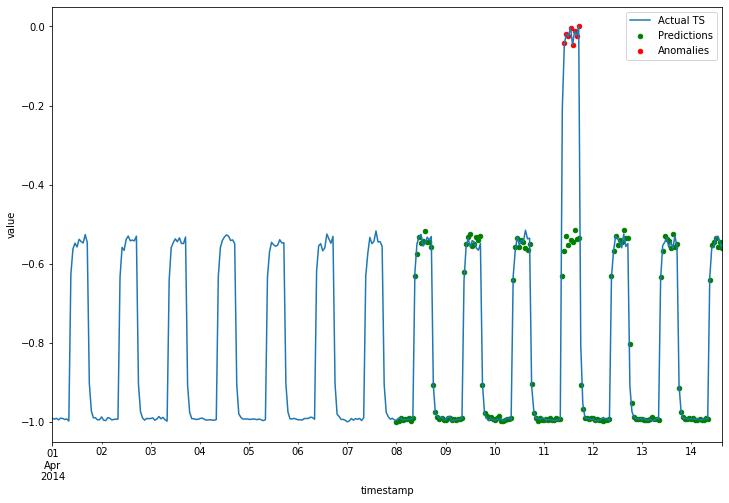

In [171]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

anomalies_df = result_df.loc[result_df["is_anomaly"] == True]
result_df["value"].plot(ax=ax)
result_df.reset_index().plot.scatter(x="timestamp", y="predictions", ax=ax, color="g")
anomalies_df.reset_index().plot.scatter(x="timestamp", y="value", ax=ax, color="r")
plt.legend(["Actual TS", "Predictions", "Anomalies"])
plt.show()